
<p align="center">
    <img loading="lazy" height=200 src="https://img.freepik.com/fotos-premium/aluno-de-fundo-de-ilustracao-de-olho-e-design-de-iris_877869-20176.jpg?size=626&ext=jpg"/ style="filter: grayscale(100%);">
</p>

# <h1 align="center"><span style="color:#5F9EA0;">**Trabalho Prático 1 - Compressão de Imagens**</span> </h1>
---

##### *Introdução a Computação Visual* <br> *UFMG 2O23*

Beatriz Reis - 2022043922<br>Izabela Tavares - 2022076332<br>Júlia Paes de Viterbo - 2021032137

## <span style="color:#5F9EA0;">**Execução**</span>

Para processar uma imagem qualquer baixe-a e coloque-a o caminho para ela dentro das aspas simples em <code>img = cv2.imread('imgs/img1.jpg', 0)</code> na sessão <a href='#1-leitura-da-imagem'>1. Leitura da Imagem</a>. <br><br>A imagem final, além de disponível para visualização no próprio notebook, também será salva no repositório atual de execução.

## <span style="color:#5F9EA0;">**Sumário**</span>

### *COMPRESSÃO:*
1. <a href='#1-leitura-da-imagem'>Leitura da Imagem</a>;
2. <a href='#2-redução-da-entropia-em-2-bits'>redução da entropia em 2 bits</a>;
3. <a href='#3-redimensionamento-para-dimensões-divisíveis-por-8'>redimensionamento para dimensões divisíveis por 8</a>;
4. <a href='#4-6-cálculo-da-dct-quantização-e-ordenação-em-zigzag'>cálculo da DCT</a>;
5. <a href='#4-6-cálculo-da-dct-quantização-e-ordenação-em-zigzag'>quantização</a>;
6. <a href='#4-6-cálculo-da-dct-quantização-e-ordenação-em-zigzag'>ordenação em zigzag</a>;
7. <a href='#7-codificação-por-comprimento-de-corrida'>codificação por comprimento de corrida</a>;
8. <a href='#8-escrita-das-frequências-codificadas-no-arquivo'>escrita do arquivo com as informações da dimensão e da codificação</a>

### *DESCOMPRESSÃO:*
1. <a href='#1-decodificação-do-comprimento-de-corrida'>decodificação do comprimento de corrida</a>;
2. <a href='#2-6-inversão-do-zigzag-dequantização-cálculo-da-dct-inversa-e-rotação-da-imagem'>inversão do zigzag</a>;
3. <a href='#2-6-inversão-do-zigzag-dequantização-cálculo-da-dct-inversa-e-rotação-da-imagem'>dequantização</a>;
4. <a href='#2-6-inversão-do-zigzag-dequantização-cálculo-da-dct-inversa-e-rotação-da-imagem'>cálculo da DCT inversa</a>;
5. <a href='#2-6-inversão-do-zigzag-dequantização-cálculo-da-dct-inversa-e-rotação-da-imagem'>rotação em 128</a>;
6. <a href='#6-cálculo-de-rmse-e-psnr'>cálculo de RMSE e PSNR</a>

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
import matplotlib.image as mpimg
import io
import os
import math
from sympy import ordered
from cv2 import imshow, multiply

#### *FUNÇÕES AUXILIARES*

In [2]:
# Cálculo da entropia 
def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

# Cálculo da DCT
def get_2D_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

# Cálculo da DCT inversa
def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

# Cálculo do RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Cálculo da PSNR
def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

# Ordenação em zigzag
def zigzag(input):
    h=0
    v=0

    vmin = 0
    hmin = 0

    vmax = input.shape[0]
    hmax = input.shape[1]

    i = 0

    output = np.zeros((vmax * hmax))
    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2 == 0):
            if(v==vmin):
                output[i] = input[v, h]
                if(h == max):
                    v = v + 1
                else:
                    h = h + 1

                i = i + 1

            elif ((h == hmax - 1) and (v < vmax)):
                output[i] = input[v,h]
                v = v + 1
                i = i + 1

            elif ((v > vmin) and (h < hmax - 1)):
                output[i] = input[v, h]
                v = v - 1
                h = h + 1
                i = i + 1

        else:
            if((v ==vmax - 1) and h <= hmax - 1):
                output[i] = input[v,h]
                h = h + 1
                i = i + 1
            elif(h == hmin):
                output[i] = input[v,h]

                if(v == vmax - 1):
                    h = h + 1
                else:
                    v = v + 1

                i = i + 1
            elif((v < vmax - 1) and (h > hmin)):
                output[i] = input[v,h]
                v = v + 1
                h = h - 1
                i = i + 1

        if((v == vmax - 1) and (h < hmax - 1)):
            output[i] = input[v,h]
            break

    return output

# Inversão da ordenação em zigzag
def inverse_zigzag(input, vmax, hmax):
    h = 0
    v = 0

    vmin = 0
    hmin = 0

    output = np.zeros((vmax, hmax))

    i = 0

    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:

            if (v == vmin):
                output[v, h] = input[i]
                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1

                i = i + 1

            elif ((h == hmax - 1) and (v < vmax)):
                output[v, h] = input[i]
                v = v + 1
                i = i + 1

            elif ((v > vmin) and (h < hmax - 1)):
                output[v, h] = input[i]
                v = v - 1
                h = h + 1
                i = i + 1

        else:

            if ((v == vmax - 1) and (h <= hmax - 1)):
                # print(4)
                output[v, h] = input[i]
                h = h + 1
                i = i + 1

            elif (h == hmin):
                output[v, h] = input[i]
                if (v == vmax - 1):
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1

            elif ((v < vmax - 1) and (h > hmin)):
                output[v, h] = input[i]
                v = v + 1
                h = h - 1
                i = i + 1

        if ((v == vmax - 1) and (h == hmax - 1)):
            output[v, h] = input[i]
            break

    return output

# Codificação por comprimento de corrida
def get_run_length_encoding(image):
    i = 0
    skip = 0
    stream = []    
    bitstream = ""
    image = image.astype(int)
    while i < image.shape[0]:
        if image[i] != 0:            
            stream.append((image[i],skip))
            bitstream = bitstream + str(image[i])+ " " +str(skip)+ " "
            skip = 0
        else:
            skip = skip + 1
        i = i + 1

    return bitstream


### *COMPRESSÃO*

#### *1. Leitura da imagem*

Entropia:  6.66610050201416


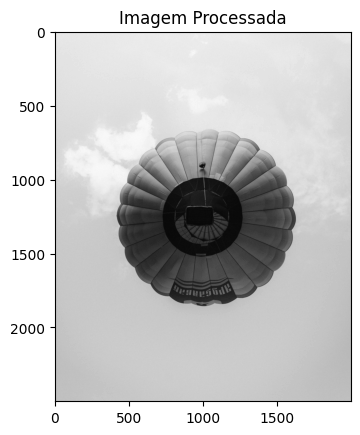

In [3]:
# Leitura da imagem original e cálculo de sua entropia

img = cv2.imread('imgs/img1.jpg', 0) #LINHA A SER ALTERADA
redim = 0
original = img

if (img.shape[0] > 2000 or img.shape[1] > 2000):
    redim = 1
    diff = img.shape[0]/img.shape[1]
    w = 2000
    h = round(w*diff)
    dim = (w,h)
    img = cv2.resize(img, dim)

oh, ow = img.shape

plt.imshow(img, cmap='gray')
plt.title('Imagem Processada')
entropia = calcEntropy(img)
print("Entropia: ", entropia)

*Lê-se a imagem, caso a imagem seja muito grande (alguma dimensão maior que 2000px) a redimensionamos proporcionalmente para 2000px. Depois mostra-se a representação da imagem em tons de cinza e calcula-se sua entropia.*

#### *2. Redução da entropia em 2 bits*

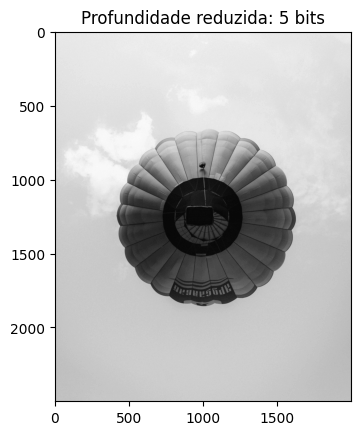

Nova entropia:  3.7668685913085938


In [4]:
if entropia > 7:
# 6 bits
    img2 = img & 0xfc
    plt.title('Profundidade reduzida: 6 bits')
    plt.imshow(img2, cmap = 'gray')
    plt.show()
    print ("Nova entropia: ", calcEntropy(img2))
    calcEntropy(img2)

elif entropia > 6:
# 5 bits 
    img2 = img & 0xf8
    plt.title('Profundidade reduzida: 5 bits')
    plt.imshow(img2, cmap = 'gray')
    plt.show()
    print ("Nova entropia: ", calcEntropy(img2))
    calcEntropy(img2)

elif entropia > 5:
# 4 bits 
    img2 = img & 0xf0
    plt.title('Profundidade reduzida: 4 bits')
    plt.imshow(img2, cmap = 'gray')
    plt.show()
    print ("Nova entropia: ", calcEntropy(img2))
    calcEntropy(img2)

elif entropia > 4:
# 3 bits
    img2 = img & 0xe0
    plt.title('Profundidade reduzida: 3 bits')
    plt.imshow(img2, cmap = 'gray')
    plt.show()
    print ("Nova entropia: ", calcEntropy(img2))

elif entropia > 3:
# 2 bits
    img2 = img & 0xc0
    plt.title('Profundidade reduzida: 2 bits')
    plt.imshow(img2, cmap = 'gray')
    plt.show()
    print ("Nova entropia: ", calcEntropy(img2))
    calcEntropy(img2)

elif entropia > 2:
# 1 bits
    img2 = img & 0x80
    plt.title('Profundidade reduzida: 1 bits')
    plt.imshow(img2, cmap = 'gray')
    plt.show()
    print ("Nova entropia: ", calcEntropy(img2))

*Aqui explora-se a redundância psico-visual, o que implica a primeira geração de perda de informação na imagem. O valor de 2 bits foi escolhido mediante testagem: observou-se que a retirada de três ou mais bits da imagem comprometia visualmente sua aparência.*

#### *3. Redimensionamento para dimensões divisíveis por 8*

Text(0.5, 1.0, 'Imagem redimensionada')

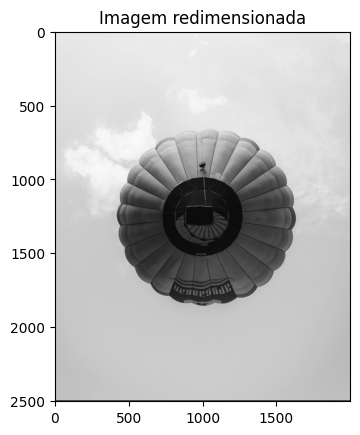

In [5]:
h = img.shape[0]
w = img.shape[1]
new_h = math.ceil(h/8)
new_h = np.int32(new_h)*8
new_w = math.ceil(w/8)
new_w = np.int32(new_w)*8
new_img = np.zeros((new_h, new_w))

for i in range(h):
    for j in range(w):
        new_img[i,j] = img[i,j]

img = new_img
plt.imshow(new_img,cmap='gray')
plt.title('Imagem redimensionada')

*Caso a imagem não possua dimensões múltiplas de 8, uma "borda" é adicionada a ela para que a DCT possa ser aplicada sem a necessidade de que uma parte da imagem seja desconsiderada nos cálculos. Note que após o cálculo da DCT essa porção a mais na imagem será removida.*

#### *4-6. Cálculo da DCT, quantização e ordenação em zigzag*

Matriz de quantização:
[[ 16.  11.  10.  16.  24.  40.  51.  61.]
 [ 12.  12.  14.  19.  26.  58.  60.  55.]
 [ 14.  13.  16.  24.  40.  57.  69.  56.]
 [ 14.  17.  22.  29.  51.  87.  80.  62.]
 [ 18.  22.  37.  56.  68. 109. 103.  77.]
 [ 24.  35.  55.  64.  81. 104. 113.  92.]
 [ 49.  64.  78.  87. 103. 121. 120. 101.]
 [ 72.  92.  95.  98. 112. 100. 103.  99.]]


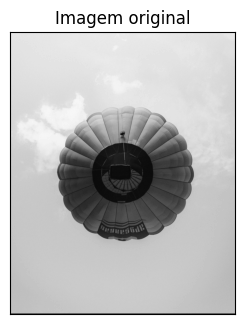

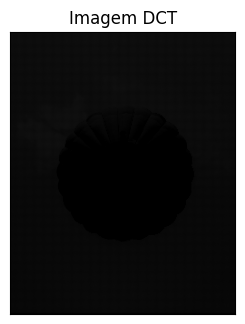

Matriz de coeficientes depois do zigzag
[[51.  0.  0. ...  0. -0. -1.]
 [ 0.  0.  0. ... -0.  0. -0.]
 [-0. -0. -0. ... -0. -0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [6]:
img = img.astype(float)
step = 8

size = img.shape
IDCT = np.zeros(size, dtype=float)
DCT = np.zeros(size, dtype=float)
DCT_R = np.zeros(size,dtype=float)


np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Matriz de quantização
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QM = QM.astype(float)

useDC = True 

print ("Matriz de quantização:")
print (QM)

img = img-128
for y in range(0,size[0],step):
    for x in range(0,size[1],step):
        dct = get_2D_dct(img[y:y+step, x:x+step])
        odct = dct
        DCT[y:y+step, x:x+step] = dct
        DC = dct[0,0]
        
        dct = np.divide(dct, QM)
        dct = dct.round()
        ordered = zigzag(dct)
        reshaped= np.reshape(ordered, (step, step)) 
        coddct = dct
        DCT_R[y:y+step, x:x+step] = reshaped

img = img + 128
        
plt.subplot(121),plt.imshow(img, cmap = 'gray', clim=(0, 255))
plt.title('Imagem original'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(DCT, cmap = 'gray', clim=(0, 255))
plt.title('Imagem DCT'), plt.xticks([]), plt.yticks([])
plt.show()

print("Matriz de coeficientes depois do zigzag")
print(DCT_R)

*Após a aplicação da DCT e da divisão dos coeficientes pela matriz de quantização, resultando em uma matriz M com coeficientes truncados, a aplicação da ordenação em zigzag retorna um vetor ordenado, que é usado para reconstruir a matriz M de modo que os valores diferentes de zero concentrem-se na parte superior da matriz. Essa é mais uma etapa de exploração da redundância psico-visual, já que estamos aproximando as frequências da imagem de forma que elas sejam o mais imperceptível possível ao olhar e, consequentemente, há perdas.<br><br>Obs.: repare que neste ponto não estamos mais no domínio espacial - fomos para o domínio de frequência.*

#### *7. Codificação por comprimento de corrida*

In [7]:
frqs = DCT_R.flatten()
frequencies = get_run_length_encoding(frqs)
frequencies = str(DCT_R.shape[0]) + " " + str(DCT_R.shape[1]) + " " + frequencies + ";"

# Printa os 10 primeiros valores do vetor para exemplificar
copia = frequencies
valores = copia.split()
for i in range(0,10):
    # Verifica se há pelo menos um valor na string
    if len(valores) > 1:
        print(valores.pop(0))
    

2504
2000
51
0
51
7
51
7
1
4


*Transforma-se a matriz M em um vetor para poder-se fazer a contagem mais facilmente. Os dois primeiros valores correspondem às dimensões da imagem seguidas dos comprimentos de corrida.*

#### *8. Escrita das frequências codificadas no arquivo*

In [8]:
with open("comp.txt", "w") as file:
    file.write(frequencies)

file.close()

*Tal codificação, presente agora no arquivo especificado, explora redundância interpixel - sem perdas.*

### *DESCOMPRESSÃO*

In [9]:
# Leitura do arquivo contendo a codificação

with open("comp.txt","r") as file:
    temp = file.read()

coded = temp.split()

h = int(''.join(filter(str.isdigit, coded[0])))
w = int(''.join(filter(str.isdigit, coded[1])))

frqs = np.zeros(h*w).astype(int)

*Abre-se o arquivo contendo a codificação por comprimento de corrida escrito anteriormente.*

#### *1. Decodificação do comprimento de corrida*

In [10]:
pixel_index = 0
i = 2
run_length = 0

while pixel_index < frqs.shape[0]:
    if(coded[i] == ';'):
        break
    if "-" not in coded[i]:
        frqs[pixel_index] = int(''.join(filter(str.isdigit, coded[i])))        
    else:
        frqs[pixel_index] = -1*int(''.join(filter(str.isdigit, coded[i])))        

    if(i+3 < len(coded)):
        run_length = int(''.join(filter(str.isdigit, coded[i+3])))

    if run_length == 0:
        pixel_index = pixel_index + 1
    else:                
        pixel_index = pixel_index + run_length + 1        

    i = i + 2

frqs = np.reshape(frqs,(h,w))

*Recria-se a matriz M com os coeficientes truncados na quantização. Note: o fato de os coeficientes terem sido previamente truncados é que gera perdas nesse método de compressão.*

#### *2-6. Inversão do zigzag, dequantização, cálculo da DCT inversa e rotação da imagem*

Um dos blocos 8x8 da imagem descomprimido:
[[-272.    0.    0.    0.    0.    0.    0.    0.]
 [ 684.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [-238.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [ 168.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [-144.    0.    0.    0.    0.    0.    0.    0.]]


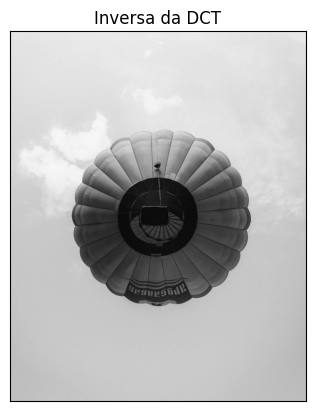

In [11]:
# Matriz de quantização
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QM = QM.astype(float)

reconstructed_image = np.zeros((h,w),float)

step = 8
for y in range(0, h, step):
    for x in range(0, w, step):
        stream = frqs[y:y+8, x:x+8]
        block = inverse_zigzag(stream.flatten(), step, step)
        block = multiply(block, QM)
        reconstructed_image[y:y+step, x:x+step] = get_2d_idct(block)

print("Um dos blocos 8x8 da imagem descomprimido:")        
print(block)
reconstructed_image = reconstructed_image + 128
reconstructed_image = reconstructed_image[:oh, :ow]

if(redim == 1):
    oh = original.shape[0]
    ow = original.shape[1]
    dim = (ow,oh)

    reconstructed_image = cv2.resize(reconstructed_image, dim)

od = oh*ow

cv2.imwrite('imagem_reconstruida.jpg', reconstructed_image)

plt.imshow(reconstructed_image, cmap = 'gray', clim=(0, 255))
plt.title('Inversa da DCT'), plt.xticks([]), plt.yticks([])
plt.show()

*Desfaz-se o zigzag na matriz M de forma que ela volta a ter um formato quase-triangular, com os coeficientes não nulos concentrados no canto superior esquerdo. Após essa etapa, multiplicam-se os coeficiente pela matriz de quantização e aplica-se a DCT inversa. Aqui saímos do domínio de frequência e voltamos para o espacial. Por fim, desloca-se a imagem para seu eixo original novamente, remove-se a borda extra e redimensiona-se a imagem para o tamanho original.*

#### *6. Cálculo de RMSE e PSNR*

In [12]:
print ("RMSE: %5.3f" % rmse(original, reconstructed_image))
print ("PSNR: %5.3f" % psnr(original, reconstructed_image))
print ("TAXA DE COMPRESSÃO: %5.3f" % ((od)/(len(coded))))

RMSE: 2.756
PSNR: 39.325
TAXA DE COMPRESSÃO: 37.002


*Calcula-se o Erro Médio Quadrático (RMSE), que sugere a diferença média do erro de cada pixel da imagem final comparada à original, e a Razão Pico Sinal-Ruído (PNSR), log(RMSE). Entende-se por consenso que compressões com PSNR:*
1. *acima de 30 dB são frequentemente consideradas boa para muitas aplicações comuns, como armazenamento de imagens.*
2. *acima de 40 dB são geralmente consideradas excelentes e adequados para aplicações de alta qualidade, como imagens médicas ou arquivamento de imagens de alta resolução.*
3. *muito alto (acima de 50 dB) são quase indistinguíveis do arquivo original e usadas em aplicações críticas, como radiologia ou arquivamento de imagens científicas.*

*Calcula-se a taxa de compressão usando L x A da imagem original / tamanho string codificada*